In [5]:
import os
import sqlite3
import pprint
from datetime import datetime
import pandas as pd 

date_format = "%Y-%m-%d %H:%M:%S.%f"
failure_list = ["dependency", "divide_zero", "environment", "memory", "ulimit"]

def get_failure_type(workflow_cnt, repeat=5):
    i = workflow_cnt//repeat
    if i >= len(failure_list):
        return "unknown"
    else:
        return failure_list[i]
    
def sorted_walk(top):
    for root, dirs, files in os.walk(top):
        dirs.sort()
        yield root, dirs, files

def process_workflow(runs_directory):
    workflow_list = []
    
    for root, dirs, files in sorted_walk(runs_directory):
        if 'monitoring.db' in files:
            info = {}
            db_path = os.path.join(root, 'monitoring.db')
            try:
                conn = sqlite3.connect(db_path)
                cursor = conn.cursor()

                info['db_dir'] = db_path

                # get run_id
                cursor.execute("SELECT run_id FROM workflow")
                rows = cursor.fetchall()
                info['run_id'] = rows[0][0]

                # get failure type
                info['failure_type'] = get_failure_type(len(workflow_list))

                # get success or not
                cursor.execute("SELECT task_fail_history FROM try WHERE task_id IS 5")
                rows = cursor.fetchall()
                info['success'] = False
                if len(rows) > 0:
                    for row in rows:
                        if row[0] == "":
                            info['success'] = True
                            break

                # get total time
                cursor.execute("SELECT task_try_time_returned, task_try_time_launched FROM try")
                rows = cursor.fetchall()
                
                total_time = 0
                for row in rows:
                    task_time_return = row[0]
                    task_time_launch = row[1]
                    if task_time_return is not None and task_time_launch is not None:
                        return_object = datetime.strptime(task_time_return, date_format)
                        return_timestamp = return_object.timestamp()
                        invoke_object = datetime.strptime(task_time_launch, date_format)
                        invoke_timestamp = invoke_object.timestamp()
                        total_time += return_timestamp - invoke_timestamp
                
                info['total_time'] = total_time
                
                conn.close()
            except sqlite3.Error as e:
                print(f"Error reading {db_path}: {e}")
            finally:
                workflow_list.append(info)
    
    return workflow_list



In [6]:
plain_list = process_workflow('without')
plain_df = pd.DataFrame(plain_list)
plain_df

,db_dir,run_id,failure_type,success,total_time
0,without/failure-injection-2024-05-31-08-20-34/...,d299ad10-d05d-4181-bf3f-56a35fb887a1,dependency,False,115.967098
1,without/failure-injection-2024-05-31-08-21-41/...,983e9026-9eab-4da4-ac4e-91d3f4da38b6,dependency,False,115.746609
2,without/failure-injection-2024-05-31-08-22-56/...,ac5de11f-b6ef-4fd2-8fcf-31f9f070037f,dependency,False,122.950469
3,without/failure-injection-2024-05-31-08-24-13/...,08b9e37b-4d00-491b-bbf9-4a1be5db02fc,dependency,False,345.707402
4,without/failure-injection-2024-05-31-08-26-16/...,5153bbe1-be97-4411-8262-16116750dea4,dependency,False,117.669252
5,without/failure-injection-2024-05-31-08-28-00/...,6659d502-53ed-40de-9c40-f2d1dad63b7e,divide_zero,False,197.548213
6,without/failure-injection-2024-05-31-08-30-13/...,f6a97a0a-2086-4869-bd68-f7a5c0f5302f,divide_zero,False,284.511601
7,without/failure-injection-2024-05-31-08-32-14/...,501ad88d-890f-4817-b530-0b4d02bff2ca,divide_zero,False,148.812892
8,without/failure-injection-2024-05-31-08-33-40/...,4edc50b3-83b8-4210-8cbd-4420d1f3f353,divide_zero,False,192.140829
9,without/failure-injection-2024-05-31-08-35-13/...,a308808d-c01f-453f-92fa-67df2e919265,divide_zero,False,284.560238


In [7]:
retry_list = process_workflow('with')
retry_df = pd.DataFrame(retry_list)
retry_df

,db_dir,run_id,failure_type,success,total_time
0,with/failure-injection-2024-05-31-07-49-55/par...,855db7da-d0c1-4be9-8d77-8b33db366785,dependency,False,54.827154
1,with/failure-injection-2024-05-31-07-50-24/par...,bddfd2f2-58d1-4949-8ac6-bdfea10e8d1b,dependency,False,59.840558
2,with/failure-injection-2024-05-31-07-50-53/par...,495d84a1-65cc-4f26-b433-93b983b5a0da,dependency,False,65.643311
3,with/failure-injection-2024-05-31-07-51-25/par...,5bfdc4db-bb5a-4534-9c38-5446a32bc570,dependency,False,50.188666
4,with/failure-injection-2024-05-31-07-51-53/par...,ec3ad262-1e09-4604-b9a5-c0327f995072,dependency,False,58.520036
5,with/failure-injection-2024-05-31-07-52-25/par...,3930ffbc-28d6-4f8e-b250-d6a5d79391eb,divide_zero,False,65.132847
6,with/failure-injection-2024-05-31-07-54-08/par...,bd66769f-bae5-47e1-a651-eb44b24818ad,divide_zero,False,92.846452
7,with/failure-injection-2024-05-31-07-55-17/par...,9bcaf1f3-161b-4f6e-b146-3083b5ea9ddf,divide_zero,False,63.948377
8,with/failure-injection-2024-05-31-07-55-49/par...,166b7612-cebb-4685-8276-62b208f48c62,divide_zero,False,58.643915
9,with/failure-injection-2024-05-31-07-56-26/par...,c086f253-c45e-4239-b117-e052e595ecdd,divide_zero,False,52.259373


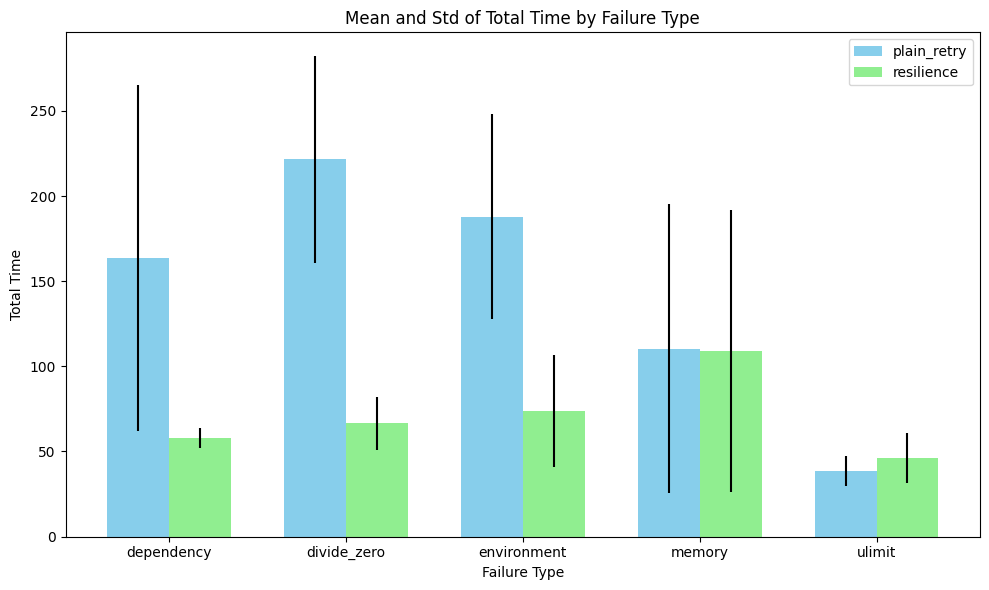

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# 计算均值和方差
stats_df1 = plain_df.groupby('failure_type')['total_time'].agg(['mean', 'std']).reset_index()
stats_df2 = retry_df.groupby('failure_type')['total_time'].agg(['mean', 'std']).reset_index()

# 合并两个DataFrame
merged_stats = pd.merge(stats_df1, stats_df2, on='failure_type', suffixes=('_df1', '_df2'))

# 设置柱状图位置
x = np.arange(len(merged_stats['failure_type']))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(10, 6))

# 绘制df1的柱状图
rects1 = ax.bar(x - width/2, merged_stats['mean_df1'], width, yerr=merged_stats['std_df1'], label='plain_retry', color='skyblue')

# 绘制df2的柱状图
rects2 = ax.bar(x + width/2, merged_stats['mean_df2'], width, yerr=merged_stats['std_df2'], label='resilience', color='lightgreen')

# 添加一些文本用于标签、标题和自定义x轴刻度
ax.set_xlabel('Failure Type')
ax.set_ylabel('Total Time')
ax.set_title('Mean and Std of Total Time by Failure Type')
ax.set_xticks(x)
ax.set_xticklabels(merged_stats['failure_type'])
ax.legend()

# 自动调整标签
fig.tight_layout()

# 显示图形
plt.show()
